#### Media Bias Detection (Using Neutrosophic Loss)

##### 1. Imports

In [ ]:
from huggingface_hub import login
# from google.colab import userdata
from datasets import load_dataset

import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import SpatialDropout1D, Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

##### 2. Load Processed Dataset

In [2]:
# load processed dataset.
file = r"/kaggle/input/bias-detection-dataset-processed/balanced_bias_data_parquet.parquet"
balanced_df = pd.read_parquet(file)

print(balanced_df)
print("\nColumns: ", balanced_df.columns)
print("\nShape: ", balanced_df.shape)

         Unnamed: 0                                               text  \
0                 0  im okay with it being there and im not religious.   
1                 1  nn chchchchina nnlets dialogue about this wond...   
2                 2  ianbetteridge firefox2, no idea what version o...   
3                 3  so kool!i didnt know he came to alaska.i was 1...   
4                 4  catwoman123 if you know the real demi moore an...   
...             ...                                                ...   
2856798     2856798  i see that someone answered on your talk page....   
2856799     2856799  sheriff joe as you affectionately call him had...   
2856800     2856800  your incredulity doesnt make your claim any mo...   
2856801     2856801  find someone elses comment to spew your islamo...   
2856802     2856802  your link is an interesting read and very bala...   

                                         biased_words  bias  sentiment  toxic  \
0                             

##### 3. Tokenisation & Padding

In [3]:
# tokenize and pad text for deep learning.
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['text'])

X = tokenizer.texts_to_sequences(balanced_df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 4. Train-Test Split

In [4]:
# target labels.
y = balanced_df[['bias', 'sentiment', 'toxic']]
print(y)
print(y.shape)

         bias  sentiment  toxic
0           1          2      0
1           1          2      0
2           1          2      0
3           1          2      0
4           1          2      0
...       ...        ...    ...
2856798     0          1      0
2856799     0          1      0
2856800     0          1      0
2856801     0          1      0
2856802     0          1      0

[2856803 rows x 3 columns]
(2856803, 3)


In [5]:
# split for training, testing and validation as 80%-10%-10%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [6]:
# convert to numpy.
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

y_train_bias = y_train["bias"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_bias = y_test["bias"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_bias = y_valid["bias"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (1999762, 100)
X_test: (428520, 100)
X_valid: (428521, 100)


##### 5. Loss Function

In [7]:
# neutrosophic loss function.
def neutrosophic_loss(alpha=1.0, beta=0.5, gamma=0.5, num_classes=None):
    def loss_fn(y_true, y_pred):
        # apply softmax to convert logits to probabilities
        y_pred = tf.nn.softmax(y_pred, axis=-1)

        # clip softmax probabilities
        y_pred = K.clip(y_pred, 1e-7, 1.0)

        # convert sparse labels to one-hot
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

        # T (probability of the correct class)
        T = K.sum(y_true_onehot * y_pred, axis=-1)

        # F (probability mass on wrong classes)
        F = 1.0 - T

        # I (normalized shannon entropy)
        entropy = -K.sum(y_pred * K.log(y_pred), axis=-1)
        max_entropy = K.log(tf.cast(num_classes, K.floatx()))
        I = entropy / max_entropy

        # final loss function
        loss = -alpha * K.log(T) + beta * F + gamma * I
        return loss
    return loss_fn

##### 6. Model Architecture

In [8]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim)(input_layer)

x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

bias_length = 3
sentiment_length = 3
toxic_length = 2

output_bias = Dense(bias_length, activation='linear', name="output_b")(x)
output_sentiment = Dense(sentiment_length, activation='linear', name="output_s")(x)
output_toxic = Dense(toxic_length, activation='linear', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_bias, output_sentiment, output_toxic])

# learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# compile model
model.compile(
    optimizer=optimizer,
    loss={
        "output_b": neutrosophic_loss(num_classes=bias_length),
        "output_s": neutrosophic_loss(num_classes=sentiment_length),
        "output_t": neutrosophic_loss(num_classes=toxic_length)
    },
    metrics={
        "output_b": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
)

model.summary()

I0000 00:00:1760283245.837443      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,565,320 (5.97 MB)

 Trainable params: 1,564,808 (5.97 MB)

 Non-trainable params: 512 (2.00 KB)

##### 7. Model Training

In [10]:
# train model.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    {
        "output_b": y_train_bias,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_b": y_valid_bias,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=10,
    batch_size=8192,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 132s 533ms/step - loss: 3.9817 - output_b_accuracy: 0.6106 - output_b_loss: 1.3748 - output_s_accuracy: 0.6083 - output_s_loss: 1.4431 - output_t_accuracy: 0.6767 - output_t_loss: 1.1472 - val_loss: 4.0130 - val_output_b_accuracy: 0.5763 - val_output_b_loss: 1.5514 - val_output_s_accuracy: 0.5429 - val_output_s_loss: 1.4999 - val_output_t_accuracy: 0.7797 - val_output_t_loss: 0.9449
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 131s 533ms/step - loss: 2.3409 - output_b_accuracy: 0.8031 - output_b_loss: 0.8263 - output_s_accuracy: 0.8433 - output_s_loss: 0.7369 - output_t_accuracy: 0.8147 - output_t_loss: 0.7613 - val_loss: 2.1176 - val_output_b_accuracy: 0.8231 - val_output_b_loss: 0.7425 - val_output_s_accuracy: 0.8689 - val_output_s_loss: 0.6111 - val_output_t_accuracy: 0.8161 - val_output_t_loss: 0.7474
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 131s 533ms/step - loss: 2.0731 - output_b_accuracy: 0.8269 - output_b_loss: 0.7448 - output_s_accuracy: 0.87

##### 8. Model Evaluation

In [11]:
bias_length = 3
sentiment_length = 3
toxic_length = 2

bias = ['Highly Biased', 'Neutral','Slightly Biased']
sentiment = ['Negative', 'Neutral', 'Positive']
toxicity = ['Not Toxic', 'Toxic']

# evaluate model.
y_pred_probs = model.predict(X_test)

y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

print("====================== Bias Task ======================")
print("Accuracy:", accuracy_score(y_test_bias, y_pred_bias))
print(classification_report(y_test_bias, y_pred_bias, target_names=bias))

print("\n==================== Sentiment Task ====================")
print("Accuracy:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=sentiment))

print("\n====================== Toxic Task ======================")
print("Accuracy:", accuracy_score(y_test_toxic, y_pred_toxic))
print(classification_report(y_test_toxic, y_pred_toxic, target_names=[str(cls) for cls in toxicity]))

13392/13392 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step
====================== Bias Task ======================
Accuracy: 0.8672547372351349
                 precision    recall  f1-score   support

  Highly Biased       0.89      0.90      0.89    122856
        Neutral       0.87      0.89      0.88    133667
Slightly Biased       0.85      0.83      0.84    171997

       accuracy                           0.87    428520
      macro avg       0.87      0.87      0.87    428520
   weighted avg       0.87      0.87      0.87    428520


==================== Sentiment Task ====================
Accuracy: 0.9121371231214412
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87     94353
     Neutral       0.94      0.89      0.91    147428
    Positive       0.91      0.95      0.93    186739

    accuracy                           0.91    428520
   macro avg       0.91      0.90      0.91    428520
weighted avg       0.91      0.91      0.91    428520


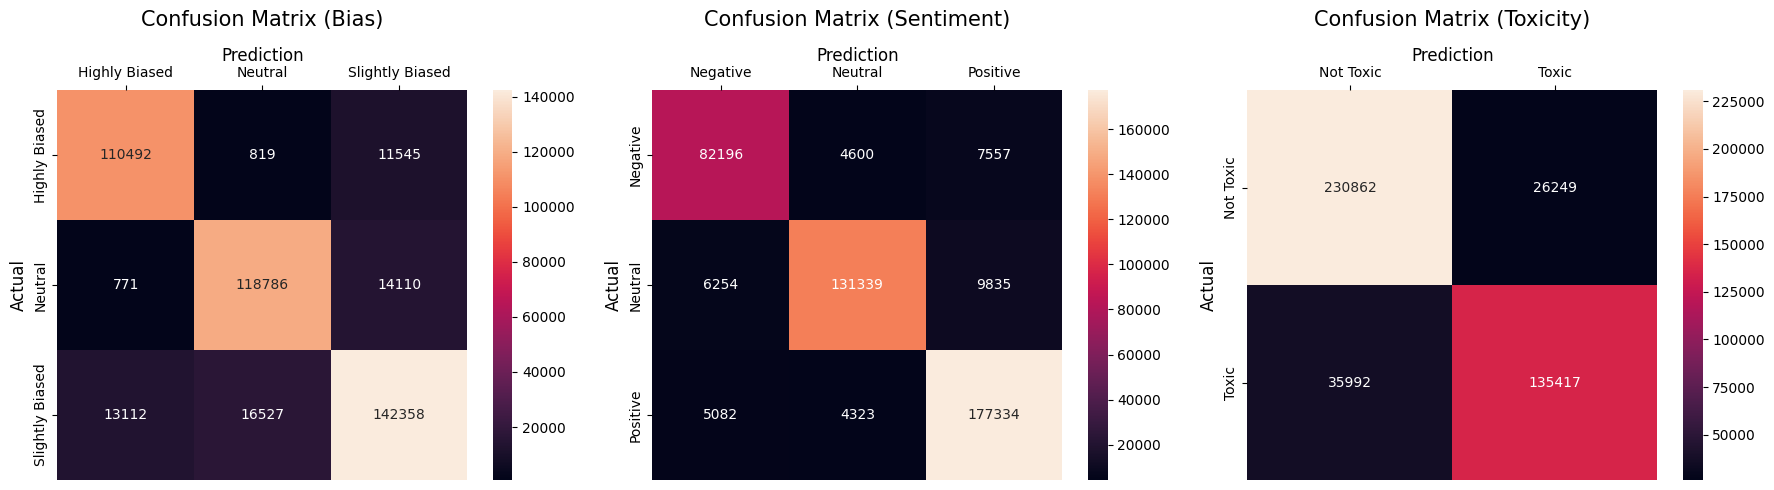

In [12]:
# confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# bias
cm_bias = confusion_matrix(y_test_bias, y_pred_bias)
sns.heatmap(cm_bias, annot=True, fmt='g', xticklabels=['Highly Biased', 'Neutral','Slightly Biased'], yticklabels=['Highly Biased', 'Neutral','Slightly Biased'], ax=axes[0])
axes[0].set_title('Confusion Matrix (Bias)', fontsize=15, pad=15)
axes[0].set_xlabel('Prediction', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].xaxis.set_label_position('top')
axes[0].xaxis.tick_top()

# sentiment
cm_sentiment = confusion_matrix(y_test_sentiment, y_pred_sentiment)
sns.heatmap(cm_sentiment, annot=True, fmt='g', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Sentiment)', fontsize=15, pad=15)
axes[1].set_xlabel('Prediction', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].xaxis.set_label_position('top')
axes[1].xaxis.tick_top()

# toxicity
cm_toxic = confusion_matrix(y_test_toxic, y_pred_toxic)
sns.heatmap(cm_toxic, annot=True, fmt='g', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'], ax=axes[2])
axes[2].set_title('Confusion Matrix (Toxicity)', fontsize=15, pad=15)
axes[2].set_xlabel('Prediction', fontsize=12)
axes[2].set_ylabel('Actual', fontsize=12)
axes[2].xaxis.set_label_position('top')
axes[2].xaxis.tick_top()

plt.tight_layout()
plt.show()

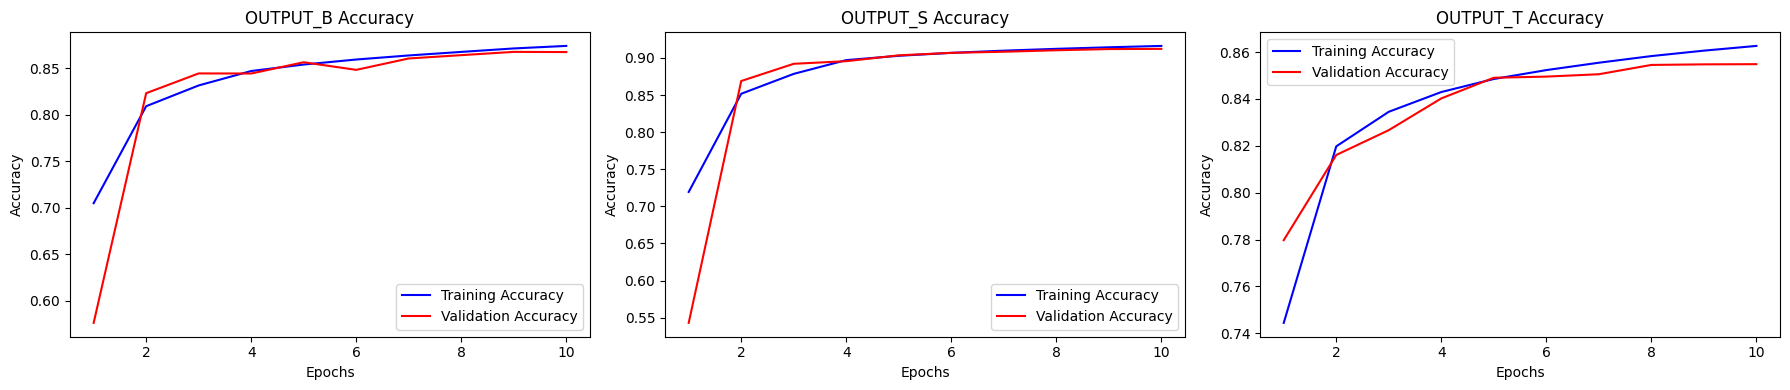

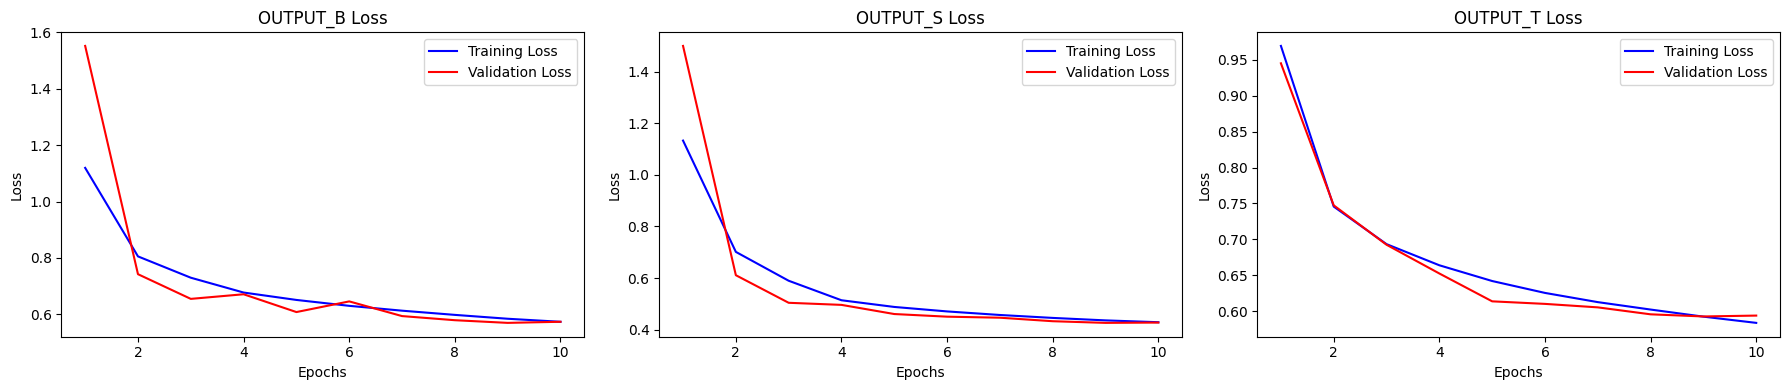

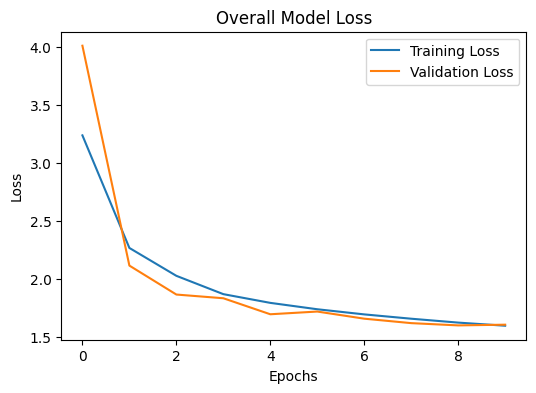

In [13]:
def plot_output(history, outputs, metric="accuracy"):
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

    # accuracy plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_metric = history.history[f"{output}_{metric}"]
        val_metric = history.history[f"val_{output}_{metric}"]

        axes[i].plot(epochs, train_metric, "b", label=f"Training {metric.title()}")
        axes[i].plot(epochs, val_metric, "r", label=f"Validation {metric.title()}")
        axes[i].set_title(f"{output.upper()} {metric.title()}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # loss plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_loss = history.history[f"{output}_loss"]
        val_loss = history.history[f"val_{output}_loss"]

        axes[i].plot(epochs, train_loss, "b", label="Training Loss")
        axes[i].plot(epochs, val_loss, "r", label="Validation Loss")
        axes[i].set_title(f"{output.upper()} Loss")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # overall loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Overall Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

outputs = ["output_b", "output_s", "output_t"]
plot_output(history, outputs, metric="accuracy")